In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
from sklearn.manifold import TSNE

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.torch.distributions import NormalOutput

from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset

from estimator import NSTransformerEstimator

2022-11-15 13:37:04.943129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
dataset = get_dataset("electricity")

In [5]:
estimator = NSTransformerEstimator(
        freq=dataset.metadata.freq,
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*6,
        
        num_feat_static_cat=len(dataset.metadata.feat_static_cat),
        cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
        embedding_dimension=[4],
        
        nhead=2,
        num_encoder_layers=4,
        num_decoder_layers=2,
        dim_feedforward=16,
        activation="gelu",
#         distr_output=NormalOutput(),
        
        batch_size=256,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(gpus="1", max_epochs=50, logger=CSVLogger(".", "lightning_logs/")),
    )

In [6]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        num_workers=0,
        cache_data=True,
    )

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus='1')` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices='1')` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_ze

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 5.81384 (best 5.81384), saving model to './lightning_logs/version_15/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 5.30009 (best 5.30009), saving model to './lightning_logs/version_15/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 5.22327 (best 5.22327), saving model to './lightning_logs/version_15/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 5.16324 (best 5.16324), saving model to './lightning_logs/version_15/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached 5.16118 (best 5.16118), saving model to './lightning_logs/version_15/checkpoints/epoch=4-step=500.ckpt' as top 1
Epoch 5, global step 600: 'train_loss' reached 5.11440 (best 5.11440), saving model to './lightning_logs/version_15/checkpoints/epoch=5-step=600.ckpt' as top 1
Epoch 6, global step 700: 'train_loss' r

In [7]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [8]:
forecasts = list(forecast_it)

In [9]:
tss = list(ts_it)

In [10]:
evaluator = Evaluator()

In [11]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 2247it [00:00, 5679.59it/s]
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [12]:
agg_metrics

{'MSE': 1781724.5784194774,
 'abs_error': 7956256.607757287,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.6950967241972331,
 'MAPE': 0.08803342068337852,
 'sMAPE': 0.10012509856340467,
 'MSIS': 5.7531162305232195,
 'QuantileLoss[0.1]': 3478920.293266617,
 'Coverage[0.1]': 0.07441403352618305,
 'QuantileLoss[0.2]': 5402669.341425225,
 'Coverage[0.2]': 0.1588785046728972,
 'QuantileLoss[0.3]': 6715046.125683066,
 'Coverage[0.3]': 0.24862780002966922,
 'QuantileLoss[0.4]': 7529602.473152747,
 'Coverage[0.4]': 0.34121421154131437,
 'QuantileLoss[0.5]': 7956256.635945873,
 'Coverage[0.5]': 0.4382695445779558,
 'QuantileLoss[0.6]': 8044083.551866634,
 'Coverage[0.6]': 0.5246995994659546,
 'QuantileLoss[0.7]': 7620498.3645335445,
 'Coverage[0.7]': 0.6233496513870345,
 'QuantileLoss[0.8]': 6596248.330454305,
 'Coverage[0.8]': 0.7274514167037531,
 'QuantileLoss[0.9]': 4582246.669930722,
 'Coverage[0.9]': 0.8389333926717

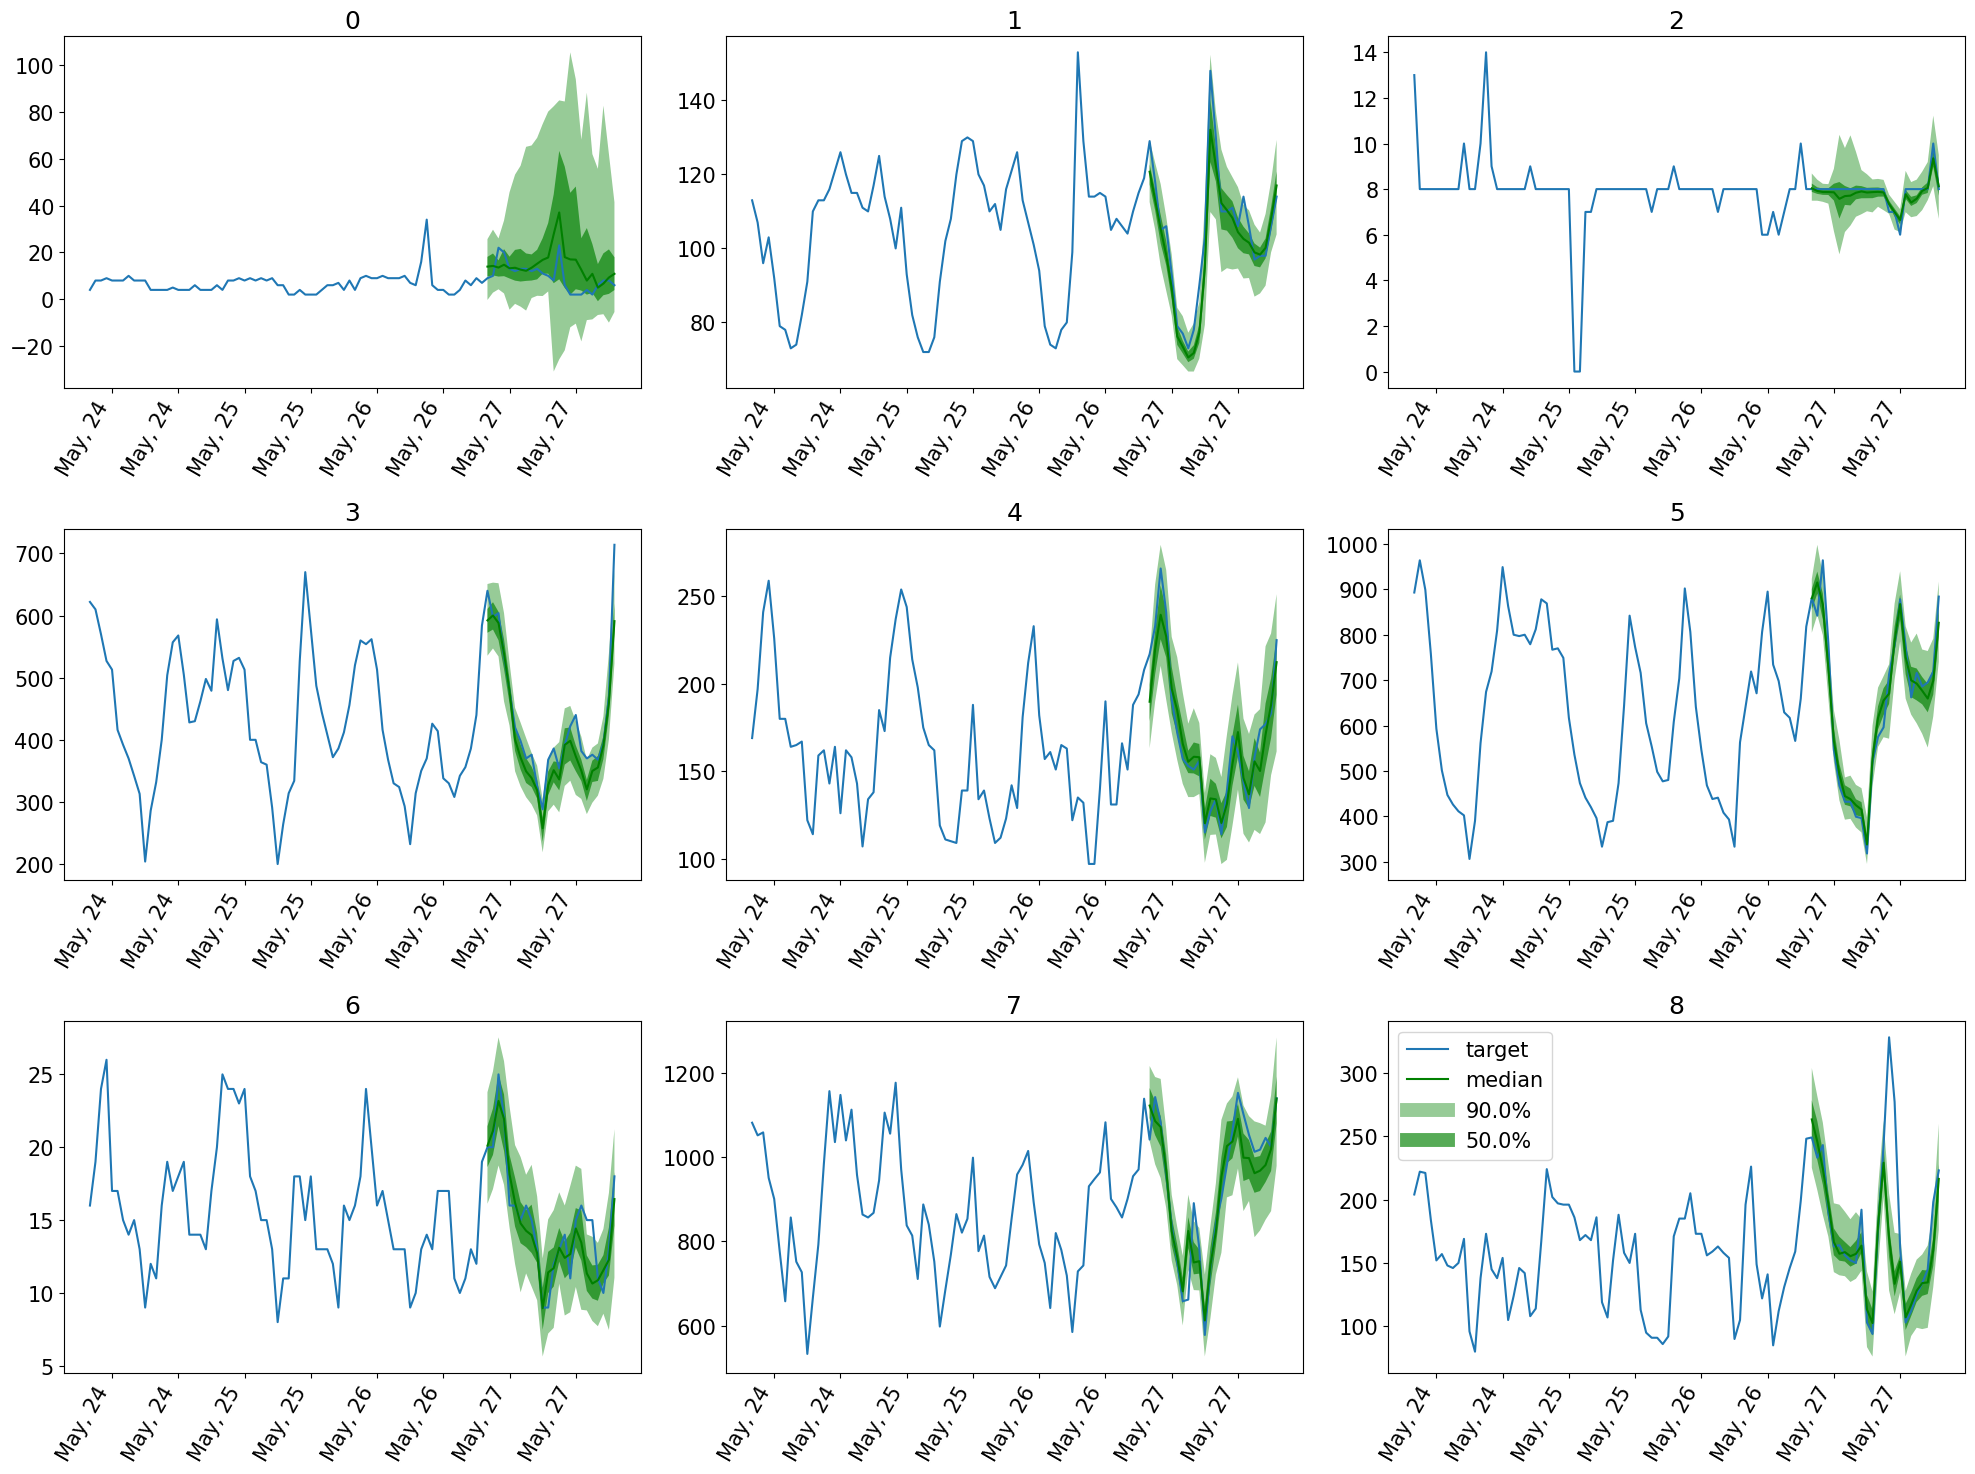

In [13]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()